## Query the CheMBL database to retrieve physical-chemical properties

In [1]:
"""
Author: Zaw
Predicting the retention time of smrt dataset
"""
import pandas as pd
import requests
import seaborn as sns
import numpy as np
import statsmodels
import pickle
import re
import csv
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
from scipy.stats import norm
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from chembl_webresource_client.new_client import new_client
IPythonConsole.ipython_useSVG=True
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn import linear_model
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error 
from tqdm.notebook import trange, tqdm
from time import sleep

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.MolStandardize.rdMolStandardize import ChargeParent
from rdkit import RDLogger
__author__ ='zaw'
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

## Reading smrt dataset

In [3]:
path = os.getcwd()
dirname = os.path.dirname(path)
data_path = dirname+"/data/SMRT_dataset.csv"
smrt_dataset = pd.read_csv(data_path, sep=';')

In [55]:
dirname

'/Users/zawmyowin/Desktop/data_curation'

In [31]:
smrt_dataset.shape

(80038, 3)

In [32]:
smrt_dataset.head()

,pubchem,rt,inchi
0,5139,93.5,"InChI=1S/C3H8N2S/c1-2-6-3(4)5/h2H2,1H3,(H3,4,5)"
1,3505,687.8,InChI=1S/C19H25Cl2N3O3/c1-27-19(26)23-8-9-24(1...
2,2159,590.7,InChI=1S/C17H27N3O4S/c1-4-20-8-6-7-12(20)11-19...
3,1340,583.6,InChI=1S/C9H7NO2/c11-8-3-1-2-7-6(8)4-5-10-9(7)...
4,3344,579.0,InChI=1S/C15H20N2O2/c18-14-16-12-15(19-14)7-10...


## Convert from InChI code to SMILES

In [6]:
inchi_code_list = smrt_dataset.inchi
rt_list = smrt_dataset.rt
new_rt_list = []
smiles_code_list = []
for (a,b) in zip(inchi_code_list,rt_list):
        try:
            d =Chem.MolToSmiles(Chem.MolFromInchi(a))
            smiles_code_list.append(d)
            new_rt_list.append(b)
        except:
            pass

In [7]:
new_smrt_dataset_list = {'rt_in_sec':new_rt_list,'SMILES':smiles_code_list,}
new_smrt_dataset = pd.DataFrame(new_smrt_dataset_list)

In [8]:
new_smrt_dataset.head()

,rt_in_sec,SMILES
0,93.5,CCSC(=N)N
1,687.8,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...
2,590.7,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1OC
3,583.6,Oc1cccc2c(O)nccc12
4,579.0,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1


## Searching the ChEMBLE for molecules in database 

In [1]:
list_molecule = new_smrt_dataset.SMILES[0:10]
exp_rt = new_smrt_dataset.rt_in_sec[0:10]
logp_list =[]
logd_list = []
psa_list = []
apka_list = []
bpka_list =[]
toxicity_list =[]
new_smiles =[]
rt_lst = []
count = 0
for (smiles,rt) in zip(list_molecule,exp_rt):
    
    try:
        molecule = new_client.molecule
        records = molecule.get([smiles])
        logp_list.append(records[0]['molecule_properties']['cx_logp'])
        logd_list.append(records[0]['molecule_properties']['cx_logd'])
        psa_list.append(records[0]['molecule_properties']['psa'])
        apka_list.append(records[0]['molecule_properties']['cx_most_apka'])
        bpka_list.append(records[0]['molecule_properties']['cx_most_bpka'])
        toxicity_list.append(records[0]['withdrawn_class'])
        new_smiles.append(smiles)
        rt_lst.append(rt)
    except:
            pass    
    count += 1
    for j in tqdm(range(100)):
        sleep(0.001)
    print('Number of molecule: '+str(count)+' have been searched.')


NameError: name 'new_smrt_dataset' is not defined

In [ ]:
data = {'SMILES':new_smiles,'LogP':logp_list,'LogD':logd_list,'PSA':psa_list,'a_pKa':apka_list,'b_pKa':bpka_list,'Toxicity':toxicity_list,'Exp_RT':rt_lst}
df = pd.DataFrame(data)
df.shape

(68, 8)

In [41]:
df

,SMILES,LogP,LogD,PSA,a_pKa,b_pKa,Toxicity,Exp_RT
0,CCSC(=N)N,0.67,-1.68,49.87,None,10.59,None,93.5
1,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,2.64,1.66,53.09,None,8.33,None,687.8
2,Oc1cccc2c(O)nccc12,1.73,1.73,53.35,9.25,2.17,None,583.6
3,NCCc1ccc(S(=O)(=O)F)cc1,1.05,-0.81,60.16,None,9.28,None,653.1
4,CNC(=O)c1cc2c(cn1)[nH]c1ccccc12,1.33,1.33,57.78,12.42,2.07,None,705.6
...,...,...,...,...,...,...,...,...
63,COc1ccc2c(c1O)-c1cccc3c1[C@@H](C2)N(C)CC3,3.24,2.74,32.70,9.73,7.72,None,642.8
64,N=C(N)NC(=N)Nc1ccccc1,0.73,-2.88,97.78,None,10.66,None,94.6
65,CC1(C)CCC=[N+]1[O-],-2.64,-0.62,26.07,2.26,None,None,487.4
66,COc1ccc(CCN(C)CCc2ccc(OC)c(OC)c2)cc1OC,3.59,1.40,40.16,None,9.60,None,668.2


In [11]:
# Save to csv in order not to search in ChEMBLE
df.to_csv(dirname+"/data/df.csv")

In [4]:
df = pd.read_csv(dirname+"/data/df_2000.csv",usecols=['SMILES','LogP','LogD','PSA','a_pKa','b_pKa','Toxicity','Exp_RT'],header=0,na_values=' ')

## Toxicity's name check

In [14]:
# There will be alot of empty dataframe. Thus, we need to fill with NaN
df['Toxicity']=[str(x)for x in df['Toxicity']]
toxic_name = [] 
lst = 0
for x in df['Toxicity']:
    if x != 'nan' :
        lst += 1
        toxic_name.append(x)
        #print(df[df.Toxicity == x]) # To check smile of Toxic compound
    else:
        pass
print('Number of toxic compounds:',lst)
print('Toxici name:',toxic_name)


Number of toxic compounds: 5
Toxici name: ['Hepatotoxicity', 'Neurotoxicity', 'Hepatotoxicity', 'Hepatotoxicity; Misuse', 'Cardiotoxicity; Neurotoxicity']


## Correlation between RT and p-chem properties

In [19]:
new_df = df.drop(['SMILES','Toxicity'],axis=1)## These two variable are string data type.

In [9]:
new_df

,LogP,LogD,PSA,a_pKa,b_pKa,Exp_RT
0,0.67,-1.68,49.87,NaN,10.59,93.5
1,2.64,1.66,53.09,NaN,8.33,687.8
2,1.73,1.73,53.35,9.25,2.17,583.6
3,1.05,-0.81,60.16,NaN,9.28,653.1
4,1.33,1.33,57.78,12.42,2.07,705.6
...,...,...,...,...,...,...
2066,2.05,1.76,83.53,7.42,3.76,603.4
2067,1.59,1.59,116.51,NaN,0.92,1061.4
2068,3.73,3.73,80.67,13.78,NaN,1059.3
2069,1.70,1.70,36.10,NaN,NaN,794.3


In [10]:
new_df[new_df['Exp_RT'] < 1]

,LogP,LogD,PSA,a_pKa,b_pKa,Exp_RT
221,-0.70,-0.70,26.30,NaN,NaN,0.3
795,3.15,2.72,59.65,NaN,7.63,0.3


In [37]:
new_df.PSA  = new_df.PSA.astype(float)
new_df.LogD = new_df.LogD.astype(float)
new_df.LogP = new_df.LogP.astype(float)
new_df.b_pKa = new_df.b_pKa.astype(float)
new_df.a_pKa = new_df.a_pKa.astype(float)
new_df.Exp_RT = new_df.Exp_RT.astype(float)

In [38]:
print('Number of NaN in LogD:',new_df.LogD.isnull().sum())
print('Number of NaN in LogP:',new_df.LogP.isnull().sum())
print('Number of NaN in PSA:',new_df.PSA.isnull().sum())
print('Number of NaN in a_pKa:',new_df.a_pKa.isnull().sum())
print('Number of NaN in b_pKa:',new_df.b_pKa.isnull().sum())
print('Number of NaN in Exp_RT:',new_df.Exp_RT.isnull().sum())

Number of NaN in LogD: 1
Number of NaN in LogP: 1
Number of NaN in PSA: 1
Number of NaN in a_pKa: 1213
Number of NaN in b_pKa: 638
Number of NaN in Exp_RT: 0


### a_pKa and b_pKa of NaN contribute 61 % and 24 %  in dataset.
### we will fill nan with mean values.

In [6]:
new_df.a_pKa = new_df.a_pKa.fillna(new_df.a_pKa.mean())
new_df.b_pKa = new_df.b_pKa.fillna(new_df.b_pKa.mean())
new_df.LogD  = new_df.LogD.fillna(new_df.LogD.mean())
new_df.LogP  = new_df.LogP.fillna(new_df.LogP.mean())
new_df.PSA   = new_df.PSA.fillna(new_df.PSA.mean())

NameError: name 'new_df' is not defined

### Need to normalize the data for correlation since they all in different scale.

In [12]:
def NormalizeData(data):
    return (data-np.min(data))/(np.max(data) - np.min(data))

In [391]:
new_df.LogP  = NormalizeData(new_df.LogP)
new_df.LogD  = NormalizeData(new_df.LogD)
new_df.PSA   = NormalizeData(new_df.PSA)
new_df.b_pKa = NormalizeData(new_df.b_pKa)
new_df.a_pKa = NormalizeData(new_df.a_pKa)

In [16]:
new_df['Exp_RT']

0       False
1       False
2       False
3       False
4       False
        ...  
2066    False
2067    False
2068    False
2069    False
2070    False
Name: Exp_RT, Length: 2071, dtype: bool

In [20]:
new_df.drop(new_df[new_df['Exp_RT'] < 180].index,inplace=True)

### Pearson's Correlation

In [21]:
new_df['Exp_RT'].min()

196.8

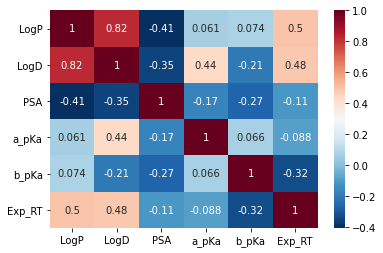

In [34]:
correlations = new_df.corr(method='pearson')
sns.heatmap(correlations,cmap='RdBu_r',annot=True)
plt.yticks(rotation=0)
plt.savefig("correlations.png", format='png', dpi=600)
plt.show()

In [32]:
from scipy import stats
# for col in new_df:
#     des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)
corr = stats.pearsonr(new_df.LogP,new_df.Exp_RT)
corr


(0.5675760285375251, 6.341496834558142e-177)

### It is worth to check the target variable distribution.

In [14]:
new_df.Exp_RT.describe()

count    2071.000000
mean      754.520473
std       234.704284
min         0.300000
25%       644.900000
50%       745.100000
75%       890.050000
max      1418.100000
Name: Exp_RT, dtype: float64

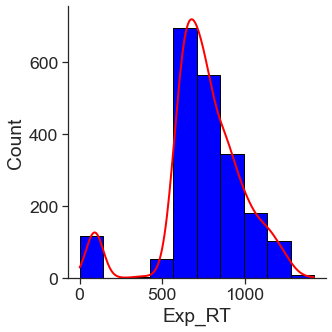

In [84]:
sns.set_style('ticks')
sns.displot(new_df['Exp_RT'],kde=True,bins=10,color='red',facecolor='blue',edgecolor='black',line_kws={'lw':2})
plt.savefig('rt.png',dpi=600)
plt.show()

### Violin plot

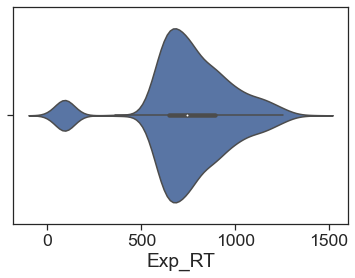

In [90]:
sns.violinplot(data=new_df,x='Exp_RT')
plt.savefig('vio_rt.png',dpi=600)
plt.show()

In [43]:
new_df.tail(50)

,LogP,LogD,PSA,a_pKa,b_pKa,Exp_RT
2021,4.55,4.55,55.84,8.84648,5.578095,1131.8
2022,3.53,2.17,30.93,8.84648,8.750000,766.3
2023,-1.51,-1.51,63.32,2.79000,9.590000,110.0
2024,4.80,2.85,75.71,8.84648,9.380000,836.9
2025,3.50,3.23,116.76,8.84648,7.340000,746.0
2026,3.11,3.02,64.99,7.99000,5.578095,1159.7
2027,2.68,0.18,63.69,8.84648,9.980000,709.4
2028,4.07,1.54,40.71,8.84648,10.020000,680.2
2029,3.44,0.65,38.33,8.84648,10.380000,706.7
2030,3.92,0.68,76.22,3.90000,5.578095,964.3


### Histogram Distribution

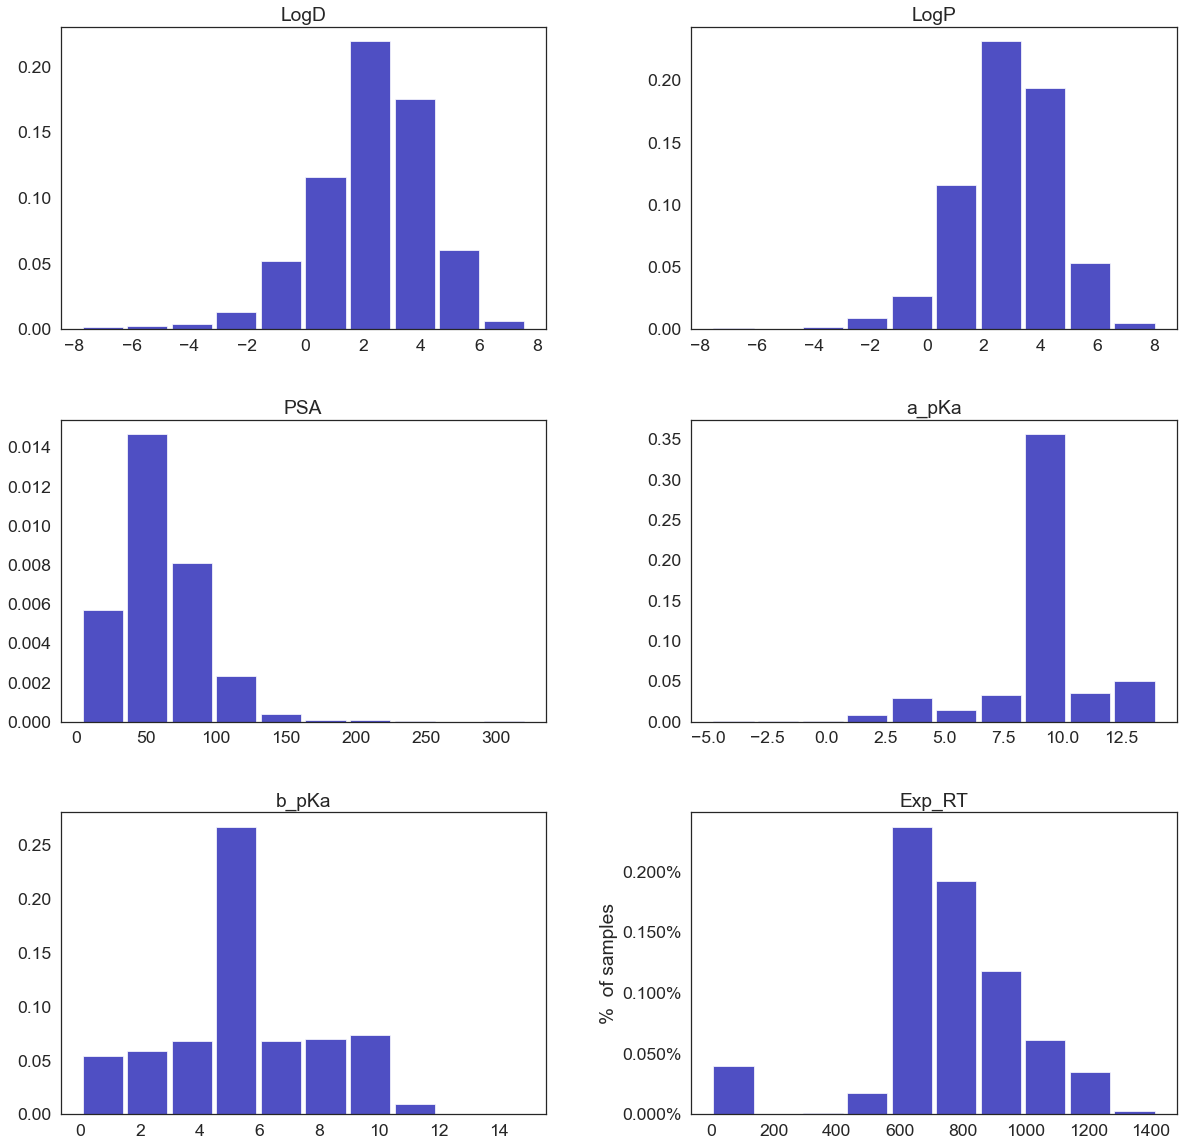

In [50]:
from matplotlib.ticker import PercentFormatter

numberical = ['LogD','LogP','PSA','a_pKa','b_pKa','Exp_RT']
new_df[numberical].hist(figsize=(20,20),grid=False,density=True,alpha=0.7,rwidth=0.90, color='#0504aa')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("distribution.png", bbox_inches='tight', dpi=600)
plt.ylabel('%  of samples')
plt.show()

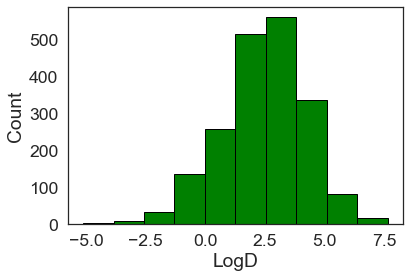

In [58]:
new_df['LogD'].hist(color='green',grid=False,edgecolor='black')
plt.xlabel('LogD')
plt.ylabel('Count')
plt.savefig(dirname+"/data/logd.png", bbox_inches='tight', dpi=600)
plt.show()


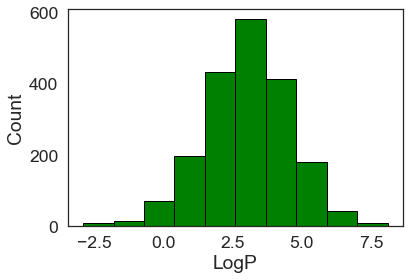

In [59]:
new_df['LogP'].hist(color='green',grid=False,edgecolor='black')
plt.xlabel('LogP')
plt.ylabel('Count')
plt.savefig(dirname+"/data/logP.png", bbox_inches='tight', dpi=600)
plt.show()

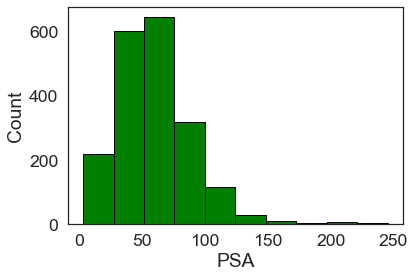

In [60]:
new_df['PSA'].hist(color='green',grid=False,edgecolor='black')
plt.xlabel('PSA')
plt.ylabel('Count')
plt.savefig(dirname+"/data/psa.png", bbox_inches='tight', dpi=600)
plt.show()

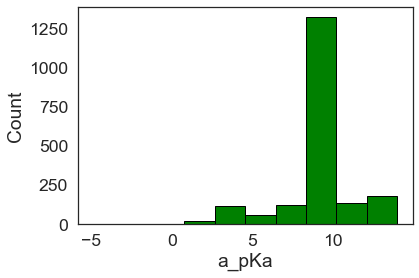

In [61]:
new_df['a_pKa'].hist(color='green',grid=False,edgecolor='black')
plt.xlabel('a_pKa')
plt.ylabel('Count')
plt.savefig(dirname+"/data/a_pKa.png", bbox_inches='tight', dpi=600)
plt.show()

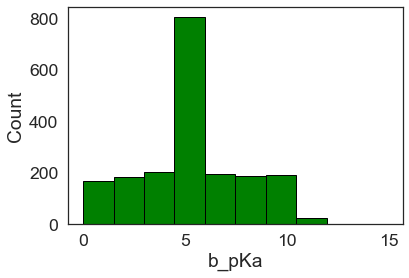

In [62]:
new_df['b_pKa'].hist(color='green',grid=False,edgecolor='black')
plt.xlabel('b_pKa')
plt.ylabel('Count')
plt.savefig(dirname+"/data/b_pKa.png", bbox_inches='tight', dpi=600)
plt.show()

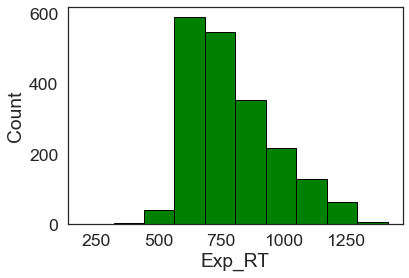

In [63]:
new_df['Exp_RT'].hist(color='green',grid=False,edgecolor='black')
plt.xlabel('Exp_RT')
plt.ylabel('Count')
plt.savefig(dirname+"/data/Exp_RT.png", bbox_inches='tight', dpi=600)
plt.show()

### Pairwise correlation

In [61]:
for x in new_df.columns:
    print(x)

LogP
LogD
PSA
a_pKa
b_pKa
Exp_RT


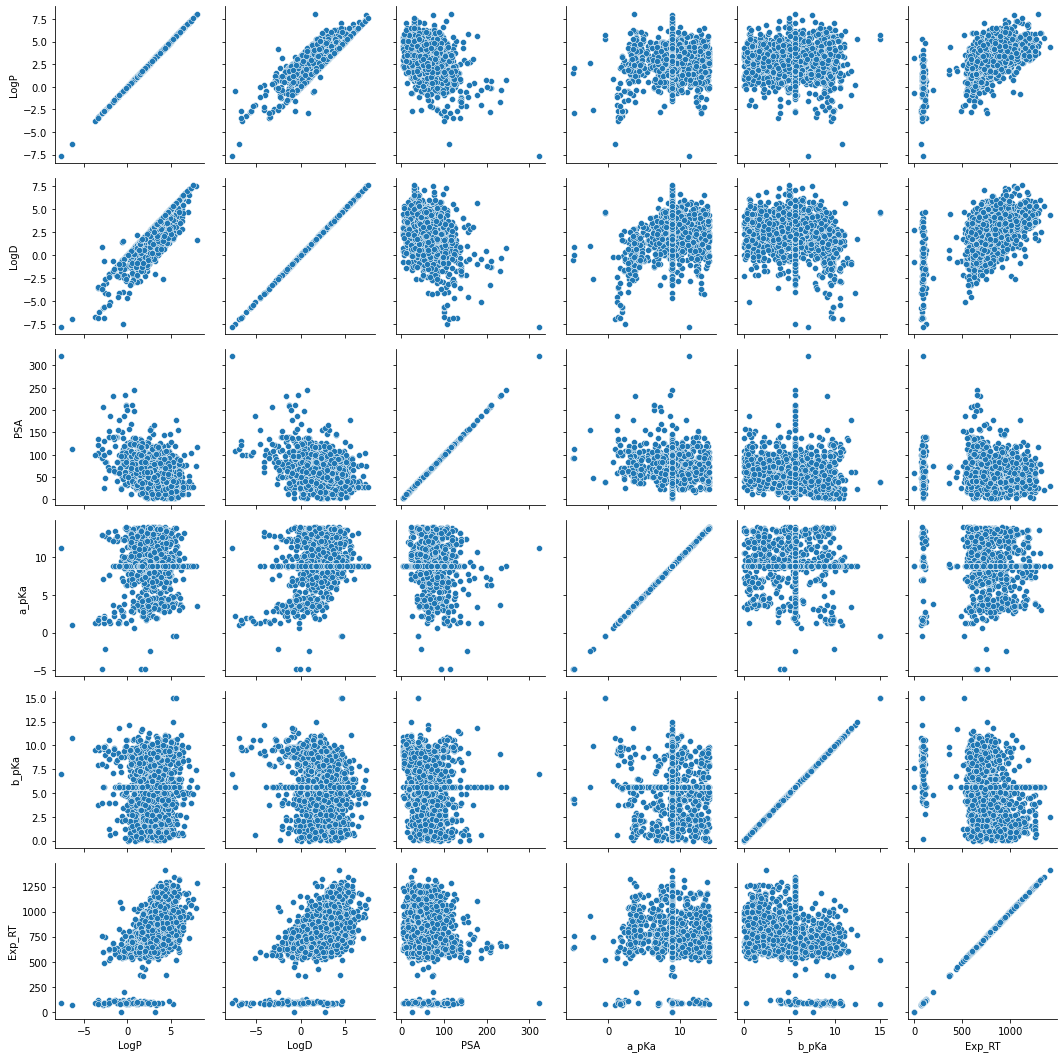

In [47]:
g = sns.PairGrid(new_df)
g.map(sns.scatterplot)

### Spearman correlation

In [364]:
new_df.corr(method = 'spearman')
#sns.heatmap(corr,annot=True)
#plt.show()

,LogP,LogD,PSA,a_pKa,b_pKa,Exp_RT
LogP,1.000000,0.819176,-0.384913,-0.008607,0.054098,0.612051
LogD,0.819176,1.000000,-0.328073,0.281767,-0.282325,0.616785
PSA,-0.384913,-0.328073,1.000000,-0.116651,-0.300451,-0.088815
a_pKa,-0.008607,0.281767,-0.116651,1.000000,0.040309,-0.208763
b_pKa,0.054098,-0.282325,-0.300451,0.040309,1.000000,-0.286465
Exp_RT,0.612051,0.616785,-0.088815,-0.208763,-0.286465,1.000000


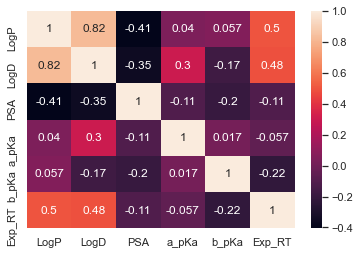

In [81]:
corr = new_df.corr(method = 'pearson')
# sns.set(font_scale=1)
sns.heatmap(corr,annot=True)
plt.savefig(dirname+"/data/pearson.png", format='png', dpi=1000)
plt.show()

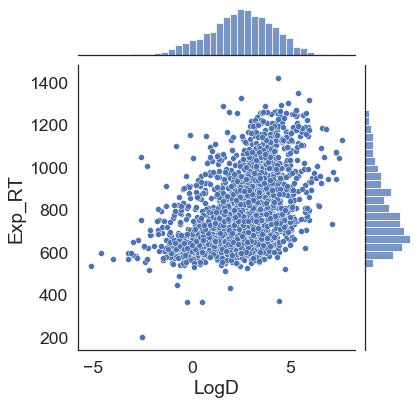

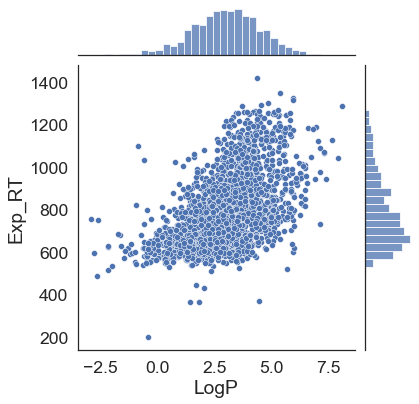

In [44]:
sns.jointplot(x = new_df.LogD,y=new_df.Exp_RT)
sns.jointplot(x = new_df.LogP,y=new_df.Exp_RT)

In [42]:
new_df.drop(new_df[new_df['Exp_RT'] < 180].index,inplace=True)

### Scatter plot matrix

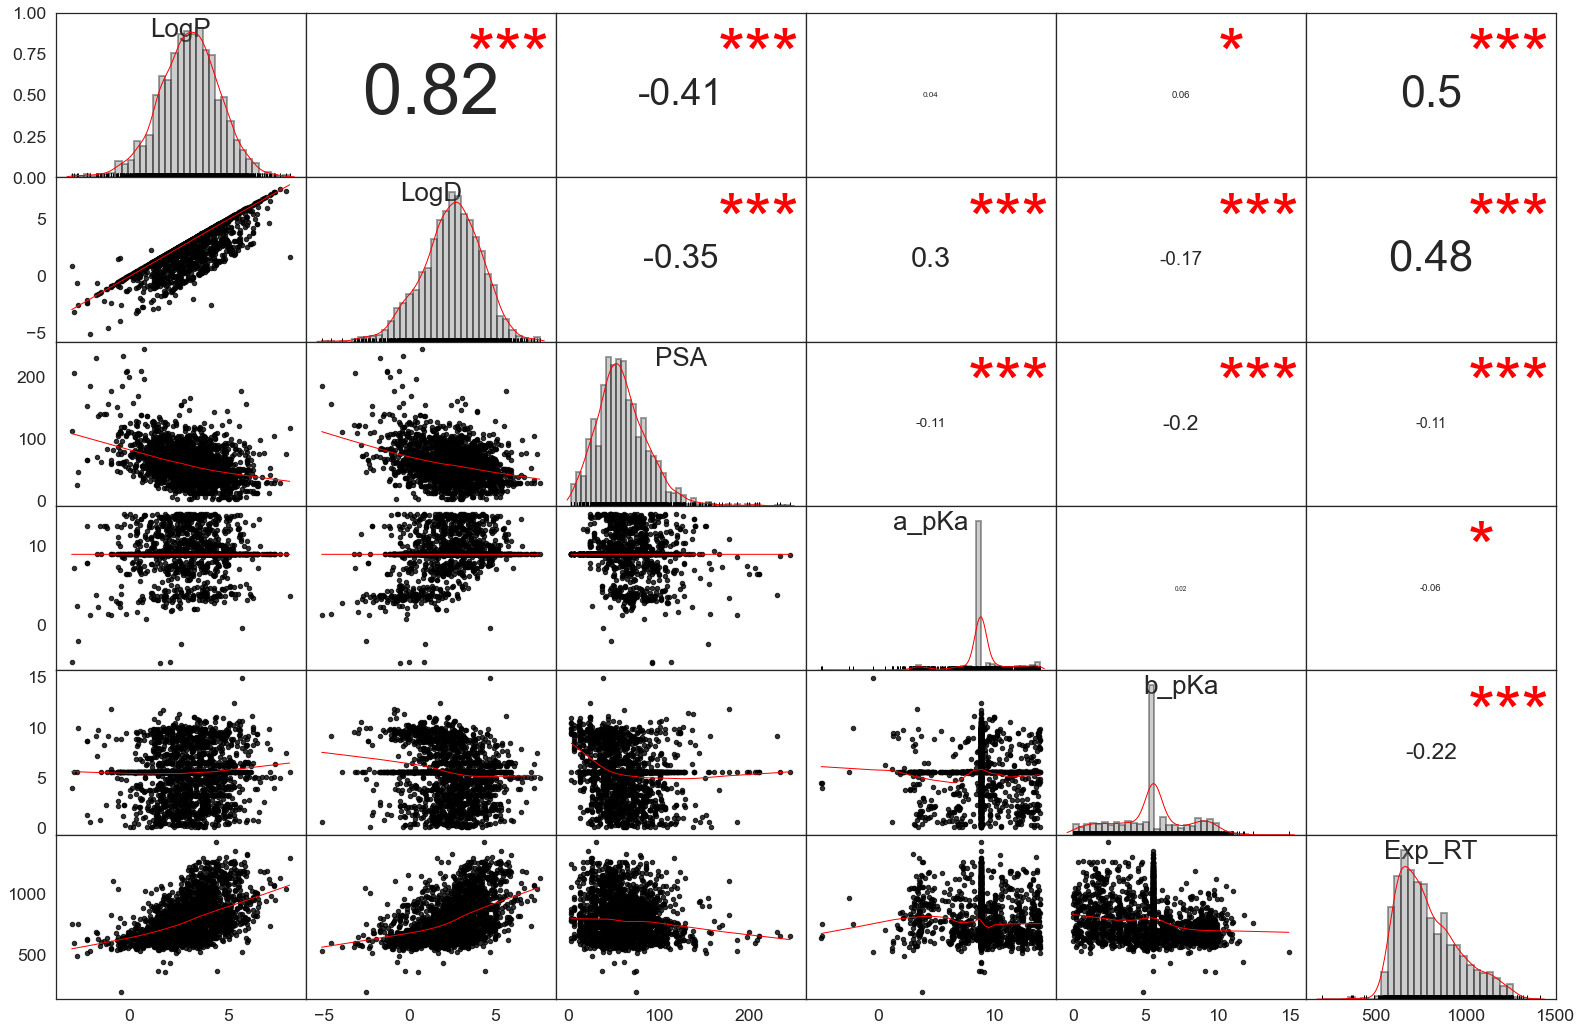

In [43]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    font_size = abs(corr_r) * 80 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='red', fontsize=70)


sns.set(style='white',font_scale=1.6)
g = sns.PairGrid(new_df, aspect=1.5, diag_sharey=False, despine=False)
g.map_lower(sns.regplot, lowess=True, ci=False,
            line_kws={'color': 'red', 'lw': 1},
            scatter_kws={'color': 'black', 's': 20})
g.map_diag(sns.distplot, color='black',
           kde_kws={'color': 'red', 'cut': 0.7, 'lw': 1},
           hist_kws={'histtype': 'bar', 'lw': 2,
                     'edgecolor': 'k', 'facecolor':'grey'})
g.map_diag(sns.rugplot, color='black')
g.map_upper(corrdot)
g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0, hspace=0)

# Remove axis labels
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

# Add titles to the diagonal axes/subplots
for ax, col in zip(np.diag(g.axes), new_df.columns):
    ax.set_title(col, y=0.82, fontsize=26)


### Zoom in jointPlot

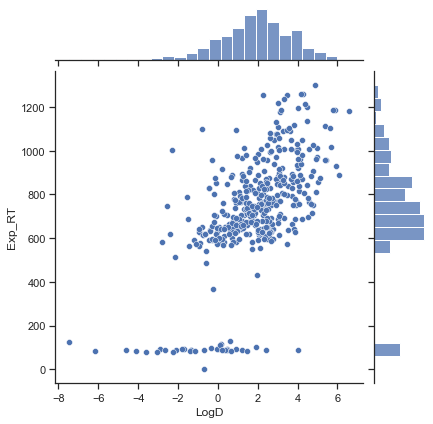

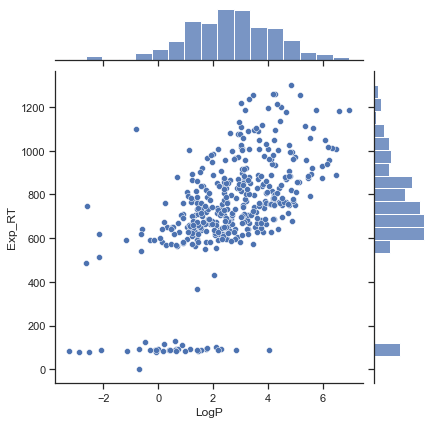

In [615]:
sns.jointplot(x = new_df.LogD,y=new_df.Exp_RT)
sns.jointplot(x = new_df.LogP,y=new_df.Exp_RT)

## Modeling